## **Applied Project 2: RLHF**

> **实践方向 (practical track)**  
> 你需要在以下 **OpenAI-Gym** 环境中测试不同的 RLHF 算法：  
> `CartPole`、`MountainCar`、`MountainCarContinuous`、`Acrobot` 以及 `Pendulum` 
> 实验应按下列步骤进行：

---

### **1.Trajectory generation 轨迹生成**

1. **训练优良策略 π₁**  
   使用你选择的任意强化学习算法，在目标环境中训练出一个可以 **稳定获得接近最高总回报** 的策略 π₁

2. **保存次优策略 π₂**  
   在训练过程中保留一个中途模型作为策略 π₂，使其总回报 `≈ ½` × （最高可达总回报）

3. **构造偏好数据集**  
   - 生成 `K` 对「首选轨迹 / 被拒轨迹」
   - 对于每一对：  
     - 用 π₁ 采样得到轨迹 `τ₁`，用 π₂ 采样得到轨迹 `τ₂`
     - 设 `R(τ)` 为轨迹 τ 的总回报，则**以下概率**判定 `τ₁` 为「首选」：  

       $$
       P\bigl(\text{τ₁ 为首选}\bigr)=
       \frac{\exp\bigl(R(\tau_1)\bigr)}
            {\exp\bigl(R(\tau_1)\bigr)+\exp\bigl(R(\tau_2)\bigr)}
       $$

---

### **2.Run RLHF 运行RLHF算法**

比较 **DPO**（Direct Preference Optimization）与 **PPO-RLHF**，并在 **至少两个** 上述环境中，针对 **不同规模的偏好数据集** 进行对比实验

> **重要说明**：  
> 每一张结果图都必须报告 **≥ 3 个随机种子** 的平均性能


In [ ]:
import os
import gymnasium as gym
from datetime import datetime
from stable_baselines3 import PPO, DQN
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnRewardThreshold
from stable_baselines3.common.monitor import Monitor
import tools

# 设置日志文件夹
# Set the log folder
current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

log_path = os.path.join("Training", current_time)
if not os.path.exists(log_path):
    os.makedirs(log_path)


################################################################################################
# 创建 Env
# Create the environment
env = gym.make("CartPole-v1")
env = Monitor(env, filename = os.path.join(log_path, "0.monitor.csv"))    # Monitor the environment for logging
env = DummyVecEnv([lambda: env])                                          # Wrap the environment in a DummyVecEnv

# 创建 PPO Agent
# Create the PPO agent
model = PPO(policy = "MlpPolicy", 
            env = env, 
            device = "cpu",                  # use device "cpu"                           # 设备类型 "cuda"， 这种情况官方建议使用 cpu
            verbose = 1,                     # Log type                                   # 日志类型
            tensorboard_log = log_path)    # Tensorboard log folder location              # Tensorboard 日志文件夹位置                  

################################################################################################
# 当奖励到达 200 就停止训练
# Stop training when the reward reaches 200
save_path_callback = os.path.join("Training", "Saved Models", "PPO_CartPole_Cut")

# 训练暂停的回调函数
# Callback function to stop training
stop_callback = StopTrainingOnRewardThreshold(reward_threshold=500, 
                                              verbose=1)
# 训练评估的回调函数
# Callback function for training evaluation
eval_callback = EvalCallback(env,
                             callback_on_new_best=stop_callback,            # 评估回调函数          # callback function for evaluation
                             eval_freq=1000,                                # 每 10000 步评估一次   # Evaluate every 10000 steps
                             best_model_save_path=save_path_callback,       # 最佳模型保存路径      # Best model save path
                             verbose=1)

print("Log path:  ", log_path)
print("Save path: ", save_path_callback)

################################################################################################
# 开始训练
# Start training
model.learn(total_timesteps = 10000,
            # callback = eval_callback # 添加回调函数 # Add callback function
            )
  
# 保存模型
# Save the model
model_save_path = os.path.join(log_path, "PPO_CartPole")
model.save(model_save_path)

OSError: [WinError 123] 文件名、目录名或卷标语法不正确。: 'Training\\2025-05-03_21:40:23'

In [ ]:
# 评估模型
# Test the model
print("Plotting path is: ", log_path)
PPO_Model_Path = os.path.join(log_path, "PPO_CartPole")
tools.test_model("PPO", PPO_Model_Path, n_episodes=1)

Plotting path is:  Training\2025-05-03_21-33-22
Training\2025-05-03_21-33-22\PPO_CartPole
Episode: 1 Score: [122.]


Plotting path is:  Training\2025-05-03_21-33-22


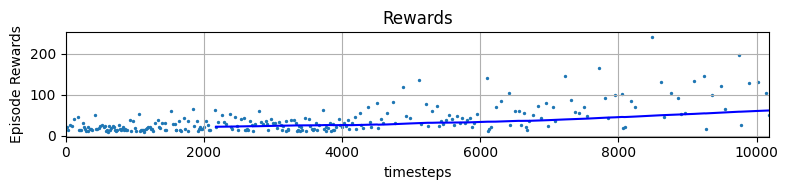

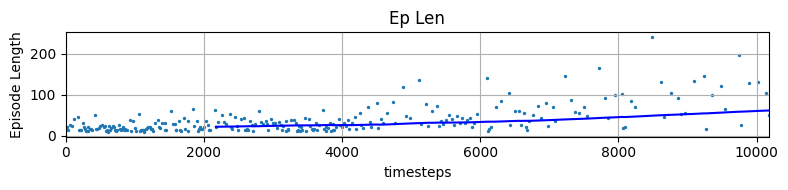

In [ ]:
# 绘制结果
# Plotting the results
import tools
print("Plotting path is: ", log_path)
tools.plot_results_test([log_path], 10e10, 'timesteps','')

In [ ]:
# !netstat -aon | findstr :6006
# %load_ext tensorboard
# %tensorboard --logdir Training/Logs/PPO_2 --port 6006